# Anime Recommendation System Project

## Imported Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
from random import randint

In [2]:

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
#from sklearn.preprocessing import MinMaxScalerort sklearn as skl

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

In [3]:

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise import Reader
from surprise import Dataset


In [4]:

from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType

from pyspark.ml.recommendation import ALS

## Datasets

#### Main Anime Dataset (anime.csv)

In [5]:
anime_main = pd.read_csv("data/anime.csv")

#### Anime Ratings Dataset (rating_complete.csv)

In [6]:
anime_ratings = pd.read_csv("data/rating_complete.csv")

In [7]:
print(anime_main.shape)
print(anime_main.columns.unique())
anime_main.head()

(17562, 35)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [8]:
print(anime_ratings.shape)
print(anime_ratings.columns.unique())
anime_ratings.head()

(57633278, 3)
Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


## Dataset Cleaning and Merging

In [9]:
# Clean main anime dataset and keep necessary features
anime_main = anime_main[['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes']]
anime_main.dropna(inplace=True)

print(anime_main.shape)
print(anime_main.columns)
anime_main.head()

(17562, 6)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes'], dtype='object')


,MAL_ID,Name,Score,Genres,Type,Episodes
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,26
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,52


In [10]:
# Rename columns and merge datasets
anime_main = anime_main.rename(columns={'MAL_ID': 'Anime ID'})
anime_ratings = anime_ratings.rename(columns={'user_id': 'User ID', 'anime_id': 'Anime ID', 'rating': 'Rating'})
anime_df = pd.merge(anime_main, anime_ratings, on='Anime ID')

In [11]:
print(anime_df.shape)
print(anime_df.columns)
anime_df.head()

(57633278, 8)
Index(['Anime ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes', 'User ID',
       'Rating'],
      dtype='object')


,Anime ID,Name,Score,Genres,Type,Episodes,User ID,Rating
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,3,9
1,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,6,6
2,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,14,9
3,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,19,8
4,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,22,9


In [12]:
anime_sample = anime_df.sample(n=1000)

## Data Visualizations

<AxesSubplot:xlabel='Type', ylabel='count'>

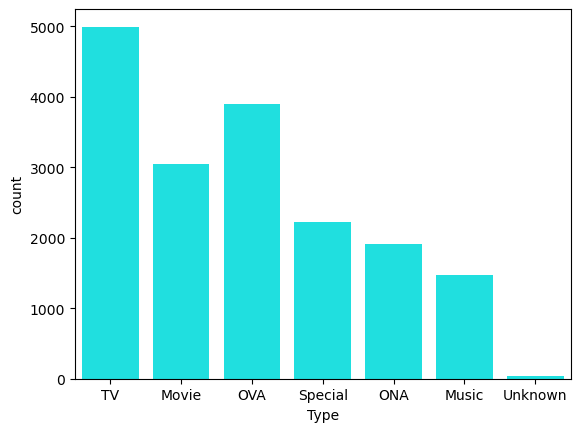

In [13]:
sns.countplot(x='Type', data=anime_main, color='cyan')

OVA = Original Video Animation, ONA = Original Net Animation

<AxesSubplot:xlabel='Rating', ylabel='count'>

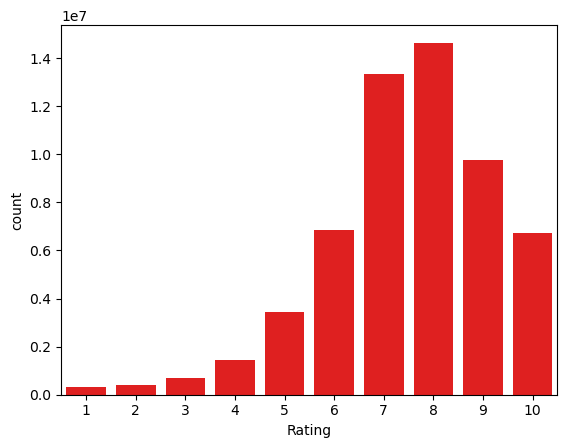

In [14]:
sns.countplot(x='Rating', data=anime_ratings, color='red')

In [15]:
# unique Genre values
genres = anime_main['Genres']
genres = pd.DataFrame([sub.split(",") for sub in genres])
pd.unique(genres.values.ravel('K'))

array(['Action', 'Adventure', 'Comedy', 'Slice of Life', 'Drama',
       'Sci-Fi', 'Samurai', 'Game', 'Harem', 'Military', 'Space', 'Music',
       'Mecha', 'Supernatural', 'Historical', 'Mystery', 'School',
       'Hentai', 'Fantasy', 'Ecchi', 'Horror', 'Kids', 'Sports',
       'Dementia', 'Magic', 'Romance', 'Police', 'Psychological', 'Cars',
       'Shounen', 'Demons', 'Parody', 'Shoujo', 'Super Power', 'Vampire',
       'Martial Arts', 'Seinen', 'Yaoi', 'Thriller', 'Josei', 'Unknown',
       'Shounen Ai', ' Adventure', ' Drama', ' Sci-Fi', ' Mystery',
       ' Fantasy', ' Sports', ' Comedy', ' Cars', ' Horror', ' Shounen',
       ' Romance', ' Supernatural', ' Military', ' Mecha', ' Dementia',
       ' Historical', ' Magic', ' Slice of Life', ' Demons', ' Harem',
       ' School', ' Ecchi', ' Psychological', ' Game', ' Super Power',
       ' Hentai', None, ' Parody', ' Music', ' Space', ' Shoujo',
       ' Josei', ' Seinen', ' Samurai', ' Martial Arts', ' Police',
       ' Kids', '

In [16]:
# Create ID to name dictionary
def read_item_names():
    file_name = "data/anime.csv"
    rid_to_name = {}
    name_to_rid = {}
    with open(file_name, encoding="ISO-8859-1") as f:
        # skip header line
        next(f)
        for line in f:
            line = line.split(",")
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid

rid_to_name, name_to_rid = read_item_names()

## Grid Search / SVD

Data Setup

In [49]:
# Sample subset of data
svd_anime_sample = anime_df.sample(n=5000)
svd_anime_sample = svd_anime_sample[['User ID', 'Anime ID', 'Rating']]

In [18]:
def create_dataset_from_df(df):
    reader = Reader(rating_scale=(1,10))
    return Dataset.load_from_df(df, reader)

# Read into Suprise dataset
svd_ratings_dataset =create_dataset_from_df(svd_anime_sample)
svd_ratings_dataset = Dataset.load_from_df(svd_anime_sample, reader)

Grid Search

In [19]:
# Grid search for optimal hyperparameters
param_grid = {
    'lr_all' : [.05, .01],
    'n_factors' : [50, 75, 100],
    'reg_all': [.05,.1],
    'n_epochs' : [50, 100, 150]
}
gridsearch_svd = GridSearchCV(
    SVD, 
    param_grid = param_grid, 
    n_jobs = -1, 
    joblib_verbose = 3)

gridsearch_svd.fit(svd_ratings_dataset)

print(gridsearch_svd.best_score)
print(gridsearch_svd.best_params)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:   20.1s remaining:   40.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   33.0s remaining:   14.1s


{'rmse': 1.5550792687899349, 'mae': 1.185241328008029}
{'rmse': {'lr_all': 0.01, 'n_factors': 75, 'reg_all': 0.05, 'n_epochs': 100}, 'mae': {'lr_all': 0.01, 'n_factors': 75, 'reg_all': 0.05, 'n_epochs': 100}}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.7s finished


Training Model Instance

In [48]:
# Create model instance from grid search optimal hyperparameters
svd_instance = gridsearch_svd.best_estimator["rmse"]
# Print Params
# print(svd_instance.__dict__)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5616  1.5463  1.5470  1.5667  1.5613  1.5566  0.0083  
MAE (testset)     1.1899  1.1767  1.1815  1.2030  1.1865  1.1875  0.0089  
Fit time          6.77    6.26    6.37    6.62    6.55    6.51    0.18    
Test time         0.05    0.04    0.04    0.04    0.04    0.04    0.00    


1.556595578616685

Basic SVD Rating Prediction Recommendation System

In [21]:
# Appends a new user to the df for refitting and predicting
# We need to do this because suprise does not support iterative training with SVD
def create_predict_dataset(base_df, anime_ids, ratings):
    predictor_df = base_df.copy()
    for i in range(len(anime_ids)):
        predictor_df.loc[len(predictor_df)] = [-1,anime_ids[i], ratings[i]]
    
    return create_dataset_from_df(predictor_df)


In [22]:

# Displays predictions for some user ID
# TODO: Should display name of anime
def show_predictions(model_instance, user_id, anime_ids, ratings_df):
    for anime_id in anime_ids:
        condition = (ratings_df['User ID'] == user_id) & (ratings_df['Anime ID'] == anime_id)
        model_instance.predict(
            user_id, 
            anime_id, 
            #ratings_df.loc[condition, 'Rating'],
            verbose = True)

# Creates a dataframe for the predictions
def get_predictions(model_instance, user_id, anime_ids):

    predict_ratings = pd.DataFrame(columns=['Anime ID', 'Rating'])

    # Use suprise model predict method to get predictions
    # This only works on userIDs that were in the training set
    for anime_id in anime_ids:
        prediction = model_instance.predict(
            user_id, 
            anime_id)

        predict_ratings.loc[len(predict_ratings)] = [anime_id, prediction.est]

    return predict_ratings

In [23]:
print(anime_ratings[anime_ratings['User ID'] == 35])
show_predictions(svd_instance, 35, [64, 6707, 6547, 4898], svd_anime_sample)

      User ID  Anime ID  Rating
4507       35        64       7
4508       35      6707       9
4509       35      6547       8
4510       35      4898       9
user: 35         item: 64         r_ui = None   est = 7.49   {'was_impossible': False}
user: 35         item: 6707       r_ui = None   est = 7.68   {'was_impossible': False}
user: 35         item: 6547       r_ui = None   est = 8.08   {'was_impossible': False}
user: 35         item: 4898       r_ui = None   est = 7.84   {'was_impossible': False}


In [24]:
# Create predictions for a mew user provided their anime ratings
# This refits the entire model with the new user appended onto the base df with a user ID of -1

def create_predictions_for_user(model_instance, base_df, anime_ids, ratings):

    # Create suprise dataset with new user
    predict_dataset = create_predict_dataset(
        base_df, 
        anime_ids,
        ratings)

    # Train on entire dataset
    # TODO: Should we do this?
    model_instance.fit(predict_dataset.build_full_trainset())
    # model_instance.fit(full_trainset)

    # Create a series of all the anime IDs that want to be predicted (all of them, more or less)
    predict_anime_ids = base_df['Anime ID'];
    predict_anime_ids = predict_anime_ids.append(pd.Series(anime_ids)).unique()
    
    # Show predictions for the known ratings
    show_predictions(model_instance, -1, anime_ids, svd_anime_sample)

    # Generate and return predictions for all the anime
    return get_predictions(model_instance, -1, predict_anime_ids)

# Print out information for top N predictions
def display_top_n(predictions, n):
    # Sort descending
    predictions = predictions.sort_values('Rating', ascending=False)
    
    print(predictions)
    print("Top {} predicted scores".format(n))
    # Print information about top n
    for index, row in predictions.head(n).iterrows():
        anime_id = row['Anime ID']
        rating = row['Rating']
        name = rid_to_name[str(int(anime_id))]
        print("Anime: {} Rating: {} Name: {}".format(anime_id, rating, name))


Tests?

In [32]:
# User 1 
# Drama / romance

user_1_anime_ids = [4224, 23273, 1723, 32281, 37450, 2167, 121]
user_1_ratings = [10, 8, 9, 9, 10, 9, 4]

# No randomness between each fit
svd_instance.random_state = 1

user_1_predictions = create_predictions_for_user(
    svd_instance,
    svd_anime_sample,
    user_1_anime_ids,
    user_1_ratings
    )

display_top_n(user_1_predictions, 25)

C:\Users\aryan\AppData\Local\Temp\ipykernel_50752\2260177929.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_anime_ids = predict_anime_ids.append(pd.Series(anime_ids)).unique()


user: -1         item: 4224       r_ui = None   est = 9.61   {'was_impossible': False}
user: -1         item: 23273      r_ui = None   est = 8.02   {'was_impossible': False}
user: -1         item: 1723       r_ui = None   est = 8.96   {'was_impossible': False}
user: -1         item: 32281      r_ui = None   est = 8.94   {'was_impossible': False}
user: -1         item: 37450      r_ui = None   est = 9.87   {'was_impossible': False}
user: -1         item: 2167       r_ui = None   est = 8.91   {'was_impossible': False}
user: -1         item: 121        r_ui = None   est = 4.69   {'was_impossible': False}
      Anime ID    Rating
1219   37450.0  9.873519
221     5114.0  9.768874
1107   39112.0  9.625468
236     4224.0  9.613840
665    38524.0  9.578468
...        ...       ...
2313   31634.0  4.747604
2507   16608.0  4.730394
669      121.0  4.686380
2412   33394.0  4.648334
5395   31578.0  4.637466

[6384 rows x 2 columns]
Top 25 predicted scores
Anime: 37450.0 Rating: 9.873518820078202 N

In [31]:
# User 1 
# Action / Adventure
user_2_pred = create_predictions_for_user(
    svd_instance,
    svd_anime_sample,
    [114, 31964, 32051, 34134, 38000],
    [9, 10, 8, 9, 9]
    )

display_top_n(user_2_pred, 25)

C:\Users\aryan\AppData\Local\Temp\ipykernel_50752\2260177929.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_anime_ids = predict_anime_ids.append(pd.Series(anime_ids)).unique()


user: -1         item: 114        r_ui = None   est = 8.99   {'was_impossible': False}
user: -1         item: 31964      r_ui = None   est = 9.73   {'was_impossible': False}
user: -1         item: 32051      r_ui = None   est = 8.08   {'was_impossible': False}
user: -1         item: 34134      r_ui = None   est = 8.92   {'was_impossible': False}
user: -1         item: 38000      r_ui = None   est = 9.07   {'was_impossible': False}
      Anime ID    Rating
429    31964.0  9.728041
1106     820.0  9.696133
221     5114.0  9.643844
1478    6594.0  9.632469
458     4565.0  9.598295
...        ...       ...
1432   19315.0  5.663073
3725   32294.0  5.656907
1531    1639.0  5.647443
2951   30705.0  5.573589
3927    3287.0  5.537984

[6384 rows x 2 columns]
Top 25 predicted scores
Anime: 31964.0 Rating: 9.72804083399295 Name: Boku no Hero Academia
Anime: 820.0 Rating: 9.696133194342366 Name: Ginga Eiyuu Densetsu
Anime: 5114.0 Rating: 9.643844251534121 Name: Fullmetal Alchemist: Brotherhood
Ani

In [27]:
# User 3 
# Boys Love
user_3_anime_ids = [114, 31964, 32051, 34134, 38000, 39533, 30346, 44055, 918]
user_3_ratings = [4, 5, 4, 6, 4, 10, 10, 9, 4]

user_3_predictions = create_predictions_for_user(
    svd_instance,
    svd_anime_sample,
    user_3_anime_ids,
    user_3_ratings
)

display_top_n(user_3_predictions, 25)

C:\Users\aryan\AppData\Local\Temp\ipykernel_50752\2260177929.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_anime_ids = predict_anime_ids.append(pd.Series(anime_ids)).unique()


user: -1         item: 114        r_ui = None   est = 4.09   {'was_impossible': False}
user: -1         item: 31964      r_ui = None   est = 5.08   {'was_impossible': False}
user: -1         item: 32051      r_ui = None   est = 4.08   {'was_impossible': False}
user: -1         item: 34134      r_ui = None   est = 6.05   {'was_impossible': False}
user: -1         item: 38000      r_ui = None   est = 4.36   {'was_impossible': False}
user: -1         item: 39533      r_ui = None   est = 9.85   {'was_impossible': False}
user: -1         item: 30346      r_ui = None   est = 9.88   {'was_impossible': False}
user: -1         item: 44055      r_ui = None   est = 8.97   {'was_impossible': False}
user: -1         item: 918        r_ui = None   est = 4.19   {'was_impossible': False}
      Anime ID    Rating
2309   30346.0  9.879264
446    39533.0  9.847979
6384   44055.0  8.969129
3250   37869.0  8.474872
167    33674.0  8.376201
...        ...       ...
2141    1647.0  3.860471
3187     413.0  3

Older SVD Stuff idk what this does

In [28]:
# from collections import defaultdict

# def get_top_n(predictions, n = 10):
#     top_n = defaultdict(list)
#     for uid, iid, true_r, est, _ in predictions:
#         top_n[uid].append((iid, est))

#     # Then sort the predictions for each user and retrieve the k highest ones.
#     for uid, user_ratings in top_n.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]

#     return top_n

In [29]:
# top_anime = get_top_n(anime_predictions,n=10)

# for uid, user_ratings in top_anime.items():
#     if len([iid for (iid, _) in user_ratings]) == 10:
#         print(uid, [iid for (iid, _) in user_ratings])

NameError: name 'anime_predictions' is not defined

In [ ]:
# user_id = -1
# anime_ids = []
# for uid, user_ratings in top_anime.items():
#     if len([iid for (iid, _) in user_ratings]) == 10:
#         user_id = uid
#         anime_ids = [iid for (iid, _) in user_ratings]
#         break
# print(user_id, anime_ids)


In [ ]:
# for anime_id in anime_ids:
#     print(anime_main.loc[anime_main['Anime ID'] == anime_id]['Name'].to_string(index=False))

## KNN 

In [37]:
knn_anime_sample = anime_df.sample(n=5000)[['User ID', 'Anime ID', 'Rating']]

reader = Reader(line_format = 'user item rating', sep='')
knn_anime_data = Dataset.load_from_df(knn_anime_sample, reader)

knn_anime_trainset = knn_anime_data.build_full_trainset()
knn_anime_testset = knn_anime_trainset.build_anti_testset()

In [41]:
simulation_variables = {"Name" : "pearson_baseline", "user_based" : False}
knn_baseline = KNNBaseline(sim_options = simulation_variables)
knn_baseline.fit(knn_anime_trainset)

anime_name = "Cowboy Bebop"
anime_raw_id = int(name_to_rid[anime_name])
anime_inner_id = knn_baseline.trainset.to_inner_iid(anime_raw_id)

anime_neighbors = knn_baseline.get_neighbors(anime_inner_id, k=10)

anime_neighbors = (
    knn_baseline.trainset.to_raw_iid(inner_id) for inner_id in anime_neighbors
)

anime_neighbors = (rid_to_name[str(rid)] for rid in anime_neighbors)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [42]:
print("The 10 nearest neighbors of", anime_name, "are:")
for anime in anime_neighbors:
    print(anime)

The 10 nearest neighbors of Cowboy Bebop are:
Mezzo Forte
Zoids Fuzors
Fate/Zero
Kiniro no Corda: Secondo Passo
Mirai Nikki
Mononoke Hime
Wotaku ni Koi wa Muzukashii
Bleach Movie 1: Memories of Nobody
Mahou no Stage Fancy Lala
Steins;Gate 0


## Cross Validation

In [45]:
knn_basic = KNNBasic(sim_options = {'name':'pearson','user_based':True})

cv_knn_baseline = cross_validate(knn_basic, knn_anime_data, n_jobs=-1)
print(np.mean(cv_knn_baseline['test_rmse']))

2.9907821892542756


In [46]:
cv_knn_baseline

{'test_rmse': array([2.98546479, 2.99583044, 2.96293773, 3.05908483, 2.95059316]),
 'test_mae': array([2.645, 2.657, 2.607, 2.73 , 2.614]),
 'fit_time': (0.43232035636901855,
  0.4418449401855469,
  0.41533398628234863,
  0.4521176815032959,
  0.4691200256347656),
 'test_time': (0.0075299739837646484,
  0.0059986114501953125,
  0.00792551040649414,
  0.006028175354003906,
  0.006009578704833984)}